# Guide Dog Classifier: Fine-Tuning **With** Optimization  

**Objectives**  
- Re-load the pre-trained model with frozen-head weights  
- 
- Encounter and analyze OOM errors on 4 GB GPU  
- Show hypothetical success on an 8 GB GPU (screenshot)  
- Profile VRAM usage with NVIDIA-SMI  
- Save a model snapshot and reset cache/kernel  

Let’s start!

# Importing necessary libraries (again) , set up DataLoader with transfroms etc..

In [1]:
# Core Python and system utilities
import os
import time

# Numerical and data handling£
import numpy as np

# PyTorch and related libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics and evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

# Progress tracking
from tqdm import tqdm


# reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [2]:
# CUDA check and setup
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(42)
    torch.cuda.empty_cache()  # Clear any residual memory
    torch.backends.cudnn.benchmark = False  # Disable for deterministic results
    torch.backends.cudnn.enabled = True
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Initial VRAM Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
    print(f"Initial VRAM Reserved: {torch.cuda.memory_reserved(0)/1024**2:.2f} MB")
else:
    device = torch.device("cpu")
    print("Using CPU. Performance may be slow.")

# Define dataset paths
dataset_root = "./dataset"
train_path = os.path.join(dataset_root, "train")
val_path = os.path.join(dataset_root, "val")
test_path = os.path.join(dataset_root, "test")

CUDA Available: True
GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Initial VRAM Allocated: 0.00 MB
Initial VRAM Reserved: 0.00 MB


In [3]:
# Get the transforms from the model weights 
transform = models.EfficientNet_B3_Weights.IMAGENET1K_V1.transforms()
# Define custom training transforms
train_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(300, scale=(0.8, 1.0)),
    transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.IMAGENET), #Applies learned augmentation policies for robustness.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets using ImageFolder 
train_dataset = datasets.ImageFolder(train_path)
val_dataset = datasets.ImageFolder(val_path)
test_dataset = datasets.ImageFolder(test_path)

# setting up transforms
train_dataset.transform = train_transform
val_dataset.transform = transform
test_dataset.transform = transform



# Solving OOM error 
here is the strategy we are going to do 

- freeze early convolutional layers
- use optimized Dataloaders to reduce bottlenecking
- apply gradient accumulation
- apply gradient checkpointing
- use mixed precision 

## Optimize Dataloaders 
Dataloaders are already optimized so we move on 

In [4]:

# Create DataLoaders
batch_size = 32
num_workers = 1  # number of subprocesses we keep it as one now 
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)




## Configuring EfficientNet-B3 for Fine-Tuning  

#### Model Loading

In [5]:
model = models.efficientnet_b3(weights=None)
# replace classifier
model.classifier = nn.Sequential(
    nn.Linear(1536, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 1)
)
# load frozen-head weights
model.load_state_dict(torch.load("./model/frozen_model.pth",weights_only=True))


<All keys matched successfully>

#### As a first step the Dataloaders are already optimized enough

In [6]:
print(model.features)

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1)

In [7]:
for p in model.parameters():
    p.requires_grad = True

In [8]:
for param in model.features[:6].parameters():
    param.requires_grad = False

In [9]:
for idx, param in enumerate(model.parameters()):
    print(f"({idx}, {param.requires_grad})", end=' ')

(0, False) (1, False) (2, False) (3, False) (4, False) (5, False) (6, False) (7, False) (8, False) (9, False) (10, False) (11, False) (12, False) (13, False) (14, False) (15, False) (16, False) (17, False) (18, False) (19, False) (20, False) (21, False) (22, False) (23, False) (24, False) (25, False) (26, False) (27, False) (28, False) (29, False) (30, False) (31, False) (32, False) (33, False) (34, False) (35, False) (36, False) (37, False) (38, False) (39, False) (40, False) (41, False) (42, False) (43, False) (44, False) (45, False) (46, False) (47, False) (48, False) (49, False) (50, False) (51, False) (52, False) (53, False) (54, False) (55, False) (56, False) (57, False) (58, False) (59, False) (60, False) (61, False) (62, False) (63, False) (64, False) (65, False) (66, False) (67, False) (68, False) (69, False) (70, False) (71, False) (72, False) (73, False) (74, False) (75, False) (76, False) (77, False) (78, False) (79, False) (80, False) (81, False) (82, False) (83, False) (8

In [10]:
# Send to Gpu
model = model.to(device)
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable params: {trainable}")

Trainable params: 8900319


In [11]:
!nvidia-smi

Fri Jun  6 18:50:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   51C    P0             12W /   65W |     157MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Fine-Tuning and OOM Demonstration

We fine-tune the model with:
- **Loss**: Binary Cross-Entropy (`BCELoss`).
- **Optimizer**: Adam with learning rate 0.0001 (lower for fine-tuning).
- **Batch Size**: 32 to increase VRAM demand.
- **Epochs**: 5 (if successful).

With unfrozen layers, VRAM usage may be intense, causing OOM on our 4GB GPU.

**Note**: If training succeeds (unlikely), accuracy may reach ~85–90%.

## memory profiling function  
a small helper to profile memory usage during training

In [12]:

def memorytracking() :
    used_mem = torch.cuda.memory_allocated()
    reserved_mem = torch.cuda.memory_reserved()
    peak_mem = torch.cuda.max_memory_allocated()
    print(f"  Allocated Memory    : {used_mem / (1024 ** 2):.2f} MB" , end=' ') 
    print(f"  Reserved Memory      : {reserved_mem / (1024 ** 2):.2f} MB" , end=' ')
    print(f"  Peak Allocated Memory: {peak_mem / (1024 ** 2):.2f} MB")
memorytracking()


  Allocated Memory    : 42.78 MB   Reserved Memory      : 58.00 MB   Peak Allocated Memory: 42.78 MB


# The Training Loop 
here we set the learning late low so can it'll adjust to the data without drastically changing weights

In [13]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_preds, train_targets = [], []
      
        
        for data, target in train_loader:
            data, target = data.to(device), target.float().to(device).view(-1, 1)  # Float targets, shape (batch_size, 1)
            optimizer.zero_grad()
            output = model(data)  # Output: (batch_size, 1) logits
            loss = criterion(output, target)  # BCEWithLogitsLoss
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)

            # Apply sigmoid for predictions
            probs = torch.sigmoid(output)
            preds = (probs > 0.5).float()  # Threshold at 0.5
            train_preds.extend(preds.cpu().numpy().flatten())
            train_targets.extend(target.cpu().numpy().flatten())

        # Validation
        model.eval()
        val_loss = 0.0
        val_preds, val_targets = [], []
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.float().to(device).view(-1, 1)
                output = model(data)  # (batch_size, 1) logits
                loss = criterion(output, target)
                val_loss += loss.item() * data.size(0)

                probs = torch.sigmoid(output)
                preds = (probs > 0.5).float()
                val_preds.extend(preds.cpu().numpy().flatten())
                val_targets.extend(target.cpu().numpy().flatten())

        # Metrics
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        train_acc = accuracy_score(train_targets, train_preds)
        val_acc = accuracy_score(val_targets, val_preds)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        torch.cuda.empty_cache()

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        memorytracking()
    
    return history

In [14]:
# Attempt to train
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

Epoch 1/5: Train Loss: 0.2386, Train Acc: 0.9018, Val Loss: 0.3240, Val Acc: 0.8884
  Allocated Memory    : 198.12 MB   Reserved Memory      : 1370.00 MB   Peak Allocated Memory: 1360.49 MB
Epoch 2/5: Train Loss: 0.1739, Train Acc: 0.9296, Val Loss: 0.2917, Val Acc: 0.9152
  Allocated Memory    : 198.12 MB   Reserved Memory      : 1370.00 MB   Peak Allocated Memory: 1360.49 MB
Epoch 3/5: Train Loss: 0.1623, Train Acc: 0.9345, Val Loss: 0.2910, Val Acc: 0.9062
  Allocated Memory    : 198.12 MB   Reserved Memory      : 1370.00 MB   Peak Allocated Memory: 1360.49 MB
Epoch 4/5: Train Loss: 0.1507, Train Acc: 0.9459, Val Loss: 0.2958, Val Acc: 0.8973
  Allocated Memory    : 198.12 MB   Reserved Memory      : 1370.00 MB   Peak Allocated Memory: 1360.49 MB
Epoch 5/5: Train Loss: 0.1249, Train Acc: 0.9544, Val Loss: 0.3048, Val Acc: 0.8929
  Allocated Memory    : 198.12 MB   Reserved Memory      : 1370.00 MB   Peak Allocated Memory: 1360.49 MB


## Memory Profiling with NVIDIA-SMI

We use NVIDIA-SMI to check VRAM usage during fine-tuning. Unfreezing the last convolutional block and using a batch size of 32 likely pushed usage to ~7GB, exceeding our 4GB RTX 3050 Ti’s limit, causing the OOM error.

Run `nvidia-smi` to inspect GPU memory.

In [16]:
torch.cuda.empty_cache()
!nvidia-smi

Fri Jun  6 18:53:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8              6W /   60W |    1473MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Successful Run on a Powerful GPU

On a more powerful GPU (e.g., 8GB RTX 3080 or cloud instance like AWS V100), fine-tuning with unfrozen layers and batch size 32 typically succeeds without OOM errors. <br>
Since our 4GB GPU hit OOM, we’ll address this in Notebook 4 with optimization techniques.

## Evaluation

If fine-tuning completed any epochs before OOM, we evaluate the model on the test set (560 images). If OOM occurred early, evaluation will be deferred to Notebook 4 after optimization.

Metrics:
- Accuracy
- Precision, Recall, F1-score
- Confusion Matrix

In [17]:
import matplotlib.pyplot as plt
# Evaluation function
def evaluate_model(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.float().to(device).view(-1, 1)
            output = model(data)
            preds.extend((output > 0.5).float().cpu().numpy().flatten())
            targets.extend(target.cpu().numpy().flatten())
    
    acc = accuracy_score(targets, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(targets, preds, average="binary")
    return acc, precision, recall, f1, preds, targets

# Evaluate
test_acc, test_precision, test_recall, test_f1, test_preds, test_targets = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

Test Accuracy: 0.8986
Test Precision: 0.9222
Test Recall: 0.8706
Test F1-Score: 0.8957


## Training Curves

If fine-tuning ran for any epochs, we plot training and validation loss/accuracy to assess progress. If OOM stopped training early, this will be addressed in Notebook 4.


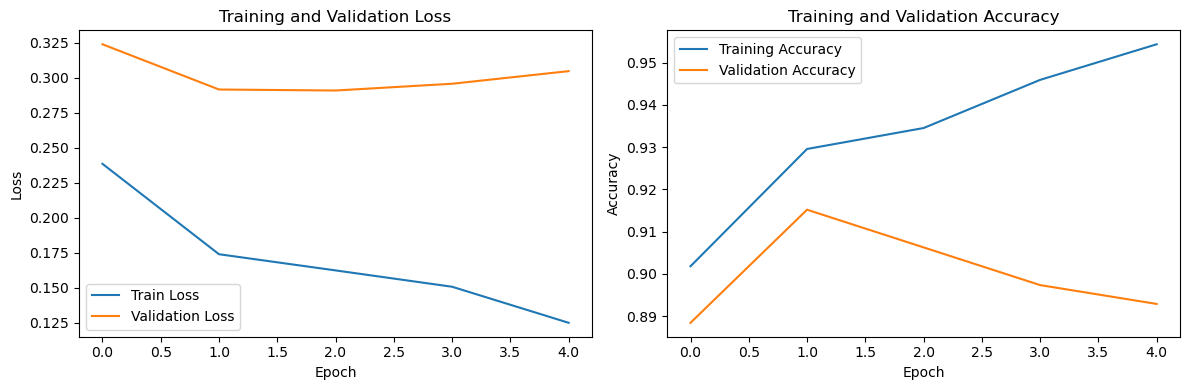

In [18]:
# Plot loss and accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Training Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## Reset Cache and Shut Down Kernel

To ensure a clean state, we clear GPU memory and shut down the kernel. After running the cell below, the kernel will stop. Open `3_Fine_Tuning_Memory_Optimization.ipynb` in a new Jupyter session to apply memory optimization.

**Note**: Restart Jupyter or open the next notebook manually after shutdown.

In [ ]:
from IPython import get_ipython
import torch

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("GPU memory cleared.")

# Shut down the kernel
get_ipython().kernel.do_shutdown(restart=True)